# Image Referred Exposure Fusion

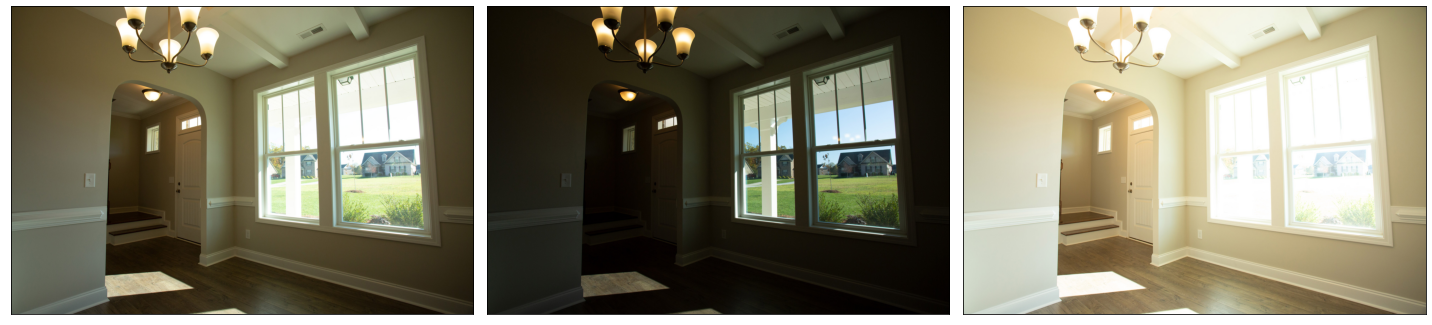

In [1]:
from matplotlib import pyplot as plt
from numpy import asarray
from PIL import Image
from torchvision.transforms import Compose, Normalize, Resize, ToPILImage, ToTensor

# Load
exposure_paths = [
    "../test/media/fusion/1.jpg",
    "../test/media/fusion/2.jpg",
    "../test/media/fusion/3.jpg"
]
exposures = [Image.open(path) for path in exposure_paths]

# Conversions
to_tensor = Compose([
    Resize(1024),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
to_image = Compose([
    Normalize(mean=[-1., -1., -1.], std=[2., 2., 2.]),
    ToPILImage()
])
to_weight_map = Compose([
    Normalize(mean=[1.], std=[1.]),
    ToPILImage()
])

# Tensors
exposure_tensors = [to_tensor(exposure).unsqueeze(dim=0) for exposure in exposures]

# Show
plt.figure(figsize=(20, 10))
for i, exposure in enumerate(exposures):
    plt.subplot(1, len(exposures), i+1)
    plt.imshow(exposure)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

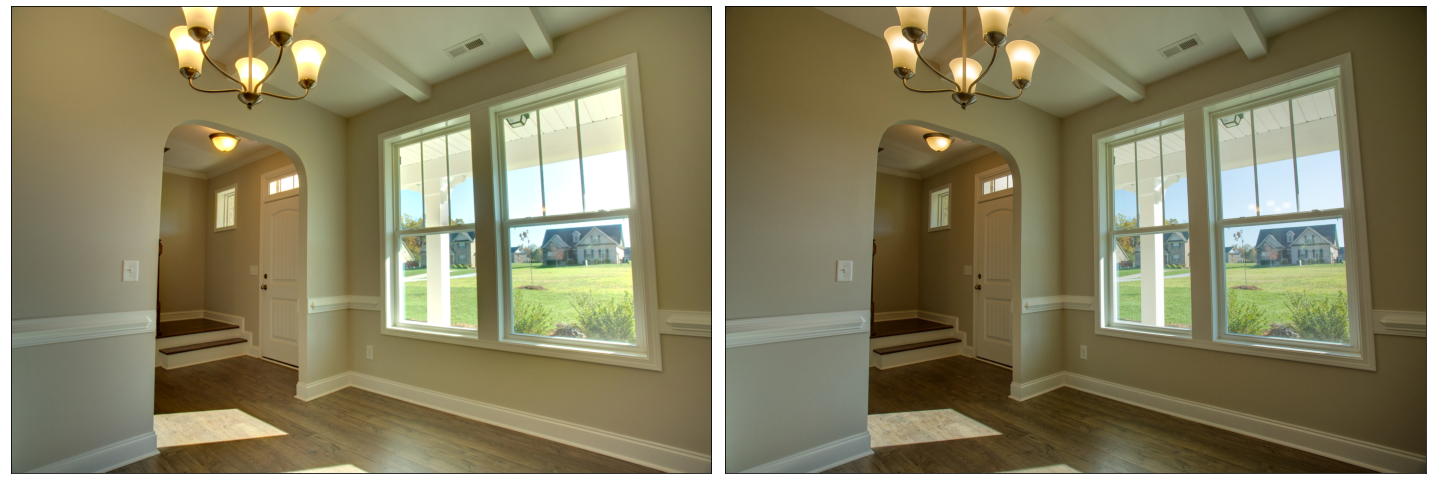

In [14]:
from plasma.fusion import exposure_fusion
from torch import cat

# Exposure fusion
exposure_stack = cat(exposure_tensors, dim=1)
mertens_fusion = exposure_fusion(exposure_stack, 1., 1.).clamp(min=-1., max=1.)
mertens_fusion = to_image(mertens_fusion.squeeze(dim=0))

# Load reference
aurora_fusion = Image.open("../test/media/fusion/123_aurora.jpg")
target_tensor = to_tensor(aurora_fusion).unsqueeze(dim=0)

# Show
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(mertens_fusion)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(aurora_fusion)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Optimization

In [25]:
from torch import cat, eye, ones, tensor, zeros
from torch.nn import Conv2d, L1Loss, Parameter, ReLU, Sequential, Sigmoid
from torch.nn.functional import normalize
from torch.optim import Adam
from plasma.blending import blend_pyramid

# Model
model = Sequential(
    Conv2d(3, 8, kernel_size=1),
    ReLU(),
    Conv2d(8, 16, kernel_size=1),
    ReLU(),
    Conv2d(16, 8, kernel_size=1),
    ReLU(),
    Conv2d(8, 1, kernel_size=1),
    Sigmoid()
)

# Optimizer
l1_loss = L1Loss()
optimizer = Adam(model.parameters(), lr=2e-3, betas=(0.5, 0.999))

# Optimize
for _ in range(100):
    # Forward
    weights = cat([model(exposure_tensor) for exposure_tensor in exposure_tensors], dim=1)
    weights = normalize(weights, p=1, dim=1, eps=1e-4)
    prediction = blend_pyramid(exposure_stack, weights, peak_level=4)
    # Backward
    optimizer.zero_grad()
    loss = l1_loss(prediction, target_tensor)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(0.0970, grad_fn=<L1LossBackward>)
tensor(0.0967, grad_fn=<L1LossBackward>)
tensor(0.0964, grad_fn=<L1LossBackward>)
tensor(0.0961, grad_fn=<L1LossBackward>)
tensor(0.0958, grad_fn=<L1LossBackward>)
tensor(0.0955, grad_fn=<L1LossBackward>)
tensor(0.0952, grad_fn=<L1LossBackward>)
tensor(0.0949, grad_fn=<L1LossBackward>)
tensor(0.0946, grad_fn=<L1LossBackward>)
tensor(0.0942, grad_fn=<L1LossBackward>)
tensor(0.0938, grad_fn=<L1LossBackward>)
tensor(0.0934, grad_fn=<L1LossBackward>)
tensor(0.0930, grad_fn=<L1LossBackward>)
tensor(0.0926, grad_fn=<L1LossBackward>)
tensor(0.0922, grad_fn=<L1LossBackward>)
tensor(0.0917, grad_fn=<L1LossBackward>)
tensor(0.0913, grad_fn=<L1LossBackward>)
tensor(0.0908, grad_fn=<L1LossBackward>)
tensor(0.0903, grad_fn=<L1LossBackward>)
tensor(0.0899, grad_fn=<L1LossBackward>)
tensor(0.0894, grad_fn=<L1LossBackward>)
tensor(0.0890, grad_fn=<L1LossBackward>)
tensor(0.0885, grad_fn=<L1LossBackward>)
tensor(0.0881, grad_fn=<L1LossBackward>)
tensor(0.0877, g

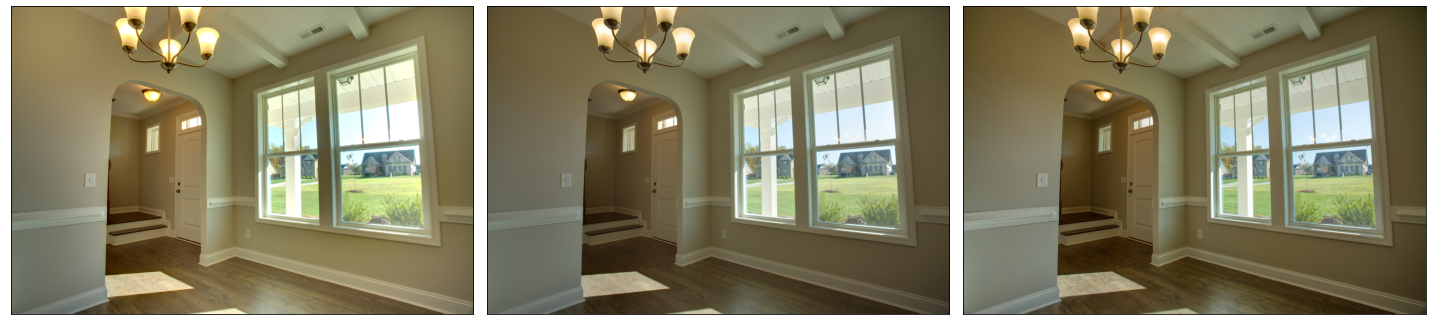

In [26]:
# Show
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(mertens_fusion)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(to_image(prediction.clamp(min=-1., max=1.).squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(aurora_fusion)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

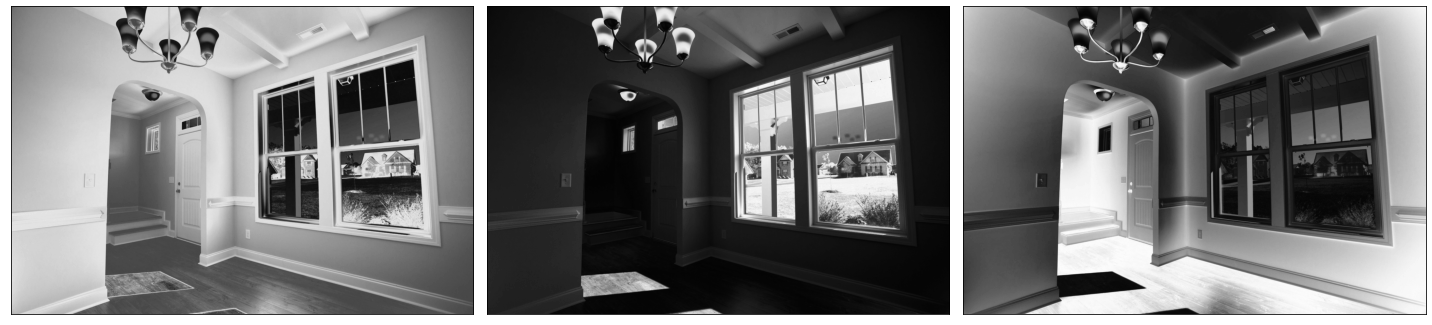

In [24]:
# Show
plt.figure(figsize=(20, 10))
plt.gray()
for i, weight in enumerate(weights.split(1, dim=1)):
    plt.subplot(1, weights.shape[1], i+1)
    plt.imshow(to_weight_map(weight.squeeze(dim=0)))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()